## Compare Regression methods for Coordinator Transformation Learning

### Background
<ol>
<li> Given camera with unknown parameter, it is impossible to use traditional camera calibration to connstruct coordinator transoformation matrix.</li>
<li> Single camera source, tradictional depth estimation methods depending on multiple sources of imaging cannot work. </li>
</ol>
    
### Goal
Learn coordinator transformation function between image coordinator and world coordinator.
### Motivation 
We observed underlying quadratic relationship between nomallized image coordinates and nomallized GPS distance between camera and object.
### Methods
we will compare below methods:
<ol>
<li>Gaussian Process Regression</li>
<li>Kernel Regression with Quadratic Kernel</li>
<li>Neural Network</li>   
</ol>

### Liscence

This research is one part of **Smooth Georeferenced Tracking from a Moving Uncalibrated Monocular Camera**. If you use below codes, please cite

```
@proceeding{Bolu2021smooth,
  author={},
  title= "{Smooth Georeferenced Tracking from a MovingUncalibrated Monocular Camera}",
  series = {Thirty-fifth Conference on Neural Information Processing Systems},
  volume={},
  number={},
  pages={},
  year={2021},
  publisher={NeurIPS}}
```
All rights reserved by FAMU-FSU Autonomous System Group (ASG). 

This research is a part of the 2nd place entry for the US Navy’s AI Tracks at Sea 2020 challenge.The current version of the software is open source at https://github.com/fsudssAI/AI-track-at-sea.

Any questions, please contact Yu Zheng(yz19b@fsu.edu), Dr. Olugbenga Anubi(oanubi@fsu.edu).


### (1) Dataset Preprocessing
<ol>
 <li> Input: Detected Trajectory in image frame. Set top left as the origin of image frame, then obtain the x-axis and y-axis coordinates $x = (a,b)$</li>
 <li> Ouputs: GPS distance between camera and object $y = (lat_d, long_d)$</li>
 <li> Oulier Removing: popular object detection methods, such as YOLO, can output the corresponding condifience for the detected trajectory. Thus, we design a outlier removing method based on the detection confidence.</li>
<li> Training dataset: quad_train_dataset_r.csv </li>
</ol>

[Text(0.5, 0, ''), Text(0, 0.5, '$delta_{lon_{norm}}$')]

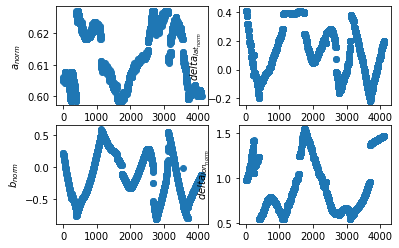

In [14]:
# preprocessing on training dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# remove outliers and remain conf in (0.75,2)
def remove_outliers(DataFrame, low_thresh, high_thresh):
    # y = df['rando']
    # removed_outliers = y.between(y.quantile(.05), y.quantile(.95))
    col = 0
    num_cols = len(DataFrame)
    mask = pd.Series([True] * num_cols, dtype=bool)
    for col in DataFrame:
        if col != 'conf':
            mask = mask.values & DataFrame[col].between(DataFrame[col].quantile(low_thresh), DataFrame[col].quantile(high_thresh))
            # filtered_entries = (z_scores >= 0.75).all(axis=1)
            # old_df = df[filtered_entries]
    return mask


data = pd.read_csv(r"C:\Users\yu zheng\OneDrive - Florida State University\Attachments\Tallahassee\At FSU\projects\AI_Tracks_at_Sea\1-Initial_version\AI-track-at-sea\data\training\quad_train_dataset_r.csv")
data.dropna(axis=0, inplace=True)
mask = remove_outliers(data, 0.1, 0.95)
mask = mask.values & data['conf'].between(0.75, 2)

# Normalizing data

# Fixed parameters
a_lim = 720  # limit (in pixels) for "a" direction
# limit (in pixels) for "b" direction (dived by 2 to allow for negative direction. Origin is at center)
b_lim = 1280 / 2

cam_lat = data.iloc[0, 5]
cam_lon = data.iloc[0, 6]

scale_factor = 1000  # used to scale the delta lat-lon data to expose enough variability

# Unpacking data
a = data.iloc[:, 0].values[:, np.newaxis]
b = data.iloc[:, 1].values[:, np.newaxis]
c = data.iloc[:, 2].values[:, np.newaxis]
gt_lat = data.iloc[:, 3].values[:, np.newaxis]
gt_lon = data.iloc[:, 4].values[:, np.newaxis]

delta_lat = gt_lat - cam_lat
delta_lon = gt_lon - cam_lon

# Normalizing data
# Input
a_norm = a / a_lim
b_norm = b / b_lim

# Output
delta_lat_norm = delta_lat * scale_factor
delta_lon_norm = delta_lon * scale_factor

# Checking correlation
fig1, axs1 = plt.subplots(2, 2)
# 1st row, 1st column (a)
axs1[0, 0].plot(a_norm[mask], 'o', label='data')
axs1[0, 0].set(xlabel=None, ylabel="$a_{norm}$")
# 2nd row, 1st column (b)
axs1[1, 0].plot(b_norm[mask], 'o', label='data')
axs1[1, 0].set(xlabel=None, ylabel="$b_{norm}$")
# 1st row, 2nd column (c)
axs1[0, 1].plot(delta_lat_norm[mask], 'o', label='data')
axs1[0, 1].set(xlabel=None, ylabel="$delta_{lat_{norm}}$")
# 2nd row, 2nd column (d)
axs1[1, 1].plot(delta_lon_norm[mask], 'o', label='data')
axs1[1, 1].set(xlabel=None, ylabel="$delta_{lon_{norm}}$")

In [17]:
# Prepare dataset
X = np.array([a_norm[:], b_norm[:]])
X = X.reshape(X.shape[0:2])
y_lat = delta_lat_norm
y_lon = delta_lon_norm
y = np.array([y_lat[:], y_lon[:]])
y = y.reshape(y.shape[0:2]).T

# train dataset
X_train = X[:,:6000]
ylat_train = y_lat[:6000]
ylon_train = y_lon[:6000]
y_train = y[:6000,:]
print(X_train.shape)
print(y_train.shape)

# test dataset
X_test = X[:,6000:]
y_test = y[6000:,:]
print(X_test.shape)
print(y_test.shape)



(2, 6000)
(6000, 2)
(2, 1243)
(1243, 2)


In [71]:
# clearn training and testing part
# when test, only use clean parts
mask_train = mask[:6000]
mask_test = mask[6000:]

### (2) Gaussian Process Regression
We simply use sklearn.gaussian_process pakeage to implement GPR with RBF kernel.

In [18]:
# Gaussian Process Regression 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,ConstantKernel, RBF
from ttictoc import tic,toc
tic()
#kernel1 = DotProduct() + WhiteKernel()
#kernel2 = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))
kernel = RBF(length_scale=1)
gpr_lat = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train.T, ylat_train)
gpr_lon = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train.T, ylon_train)

#gpr_lat.score(X[:,mask].T, y_lat[mask])
#gpr_lon.score(X[:,mask].T, y_lon[mask])

#gpr_lat.predict(X[:,mask].T, return_std=True)
#gpr_lon.predict(X[:,mask].T, return_std=True)
elapsed = toc()
print('Elapsed time:',elapsed)

Elapsed time: 49.50136840000005


c:\python38\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


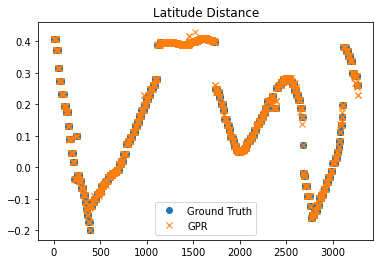

In [22]:
# plotting for GPR Result on Training dataset
lat_gpr_mean, lat_gpr_std = gpr_lat.predict(X_train[:,mask_train].T, return_std=True)
plt.plot(ylat_train[mask_train],'o',label='Ground Truth')
plt.plot(lat_gpr_mean,'x',label='GPR')
plt.title('Latitude Distance')
plt.legend()
plt.show()

c:\python38\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


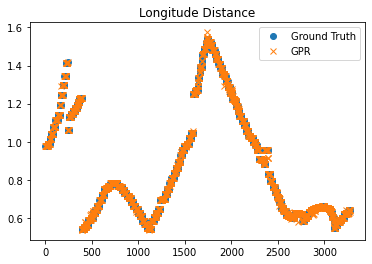

In [23]:
long_gpr_mean,long_gpr_std= gpr_lon.predict(X_train[:,mask_train].T, return_std=True)
plt.plot(ylon_train[mask_train],'o',label='Ground Truth')
plt.plot(long_gpr_mean,'x',label='GPR')
plt.title('Longitude Distance')
plt.legend()
plt.show()

### (3) Kernerl regression with quadratic kernel
Please refer to our paper attached in the beginning for the algorithm development.

In [24]:
# quadratic fit

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.linalg import lstsq




def vec(v_matrix):
    n = v_matrix.shape[0]  # implement a catch here to validate Symmetricity of matrix
    v = np.zeros((int(0.5 * n * (n + 1)), 1))  # initializing v
    start_index = 0

    for index in range(n):
        end_index = start_index + (n - index)
        v[start_index:end_index] = np.diag(v_matrix, index)[:, np.newaxis]
        start_index = end_index

    return v

def quad_fun(x, q):
    # convert x to column vector
    if type(x) == np.ndarray:
        if len(x.shape) == 1:
            x = x[:, np.newaxis]  # for 1-D array
        elif x.shape[0] == 1:
            x = x.T  # for n-D array

    tmp = np.vstack((x, 1))
    Z = np.dot(tmp, tmp.T)
    z = vec(Z)

    y = np.dot(q.T, z)
    return y


def quad_predict(X, q_lat, q_lon):
    # packing input

    # calling quad_fun
    delta_lat_quad = quad_fun(X, q_lat)
    delta_lon_quad = quad_fun(X, q_lon)
    # print(delta_lat_quad, delta_lon_quad)

    # # un-normalizing data
    #lat = cam_lat + delta_lat_quad / scale_factor
    #lon = cam_lon + delta_lon_quad / scale_factor
    return delta_lat_quad, delta_lon_quad


def train_quad(X_matrix, y_vec):
    # unpack sizes
    n, N, *tmp = X_matrix.shape

    # initialize
    m = int(0.5 * (n + 1) * (n + 2))
    A = np.zeros((m, m))
    b = np.zeros((m, 1))

    for index in range(N):
        # current input-output sample
        if len(y_vec.shape) == 1:
            y_i = y_vec[index]
            x_i = X_matrix[:, index][:, np.newaxis]
        else:
            try:
                # row vector
                y_i = y_vec[0, index]
                x_i = X_matrix[:, index][:, np.newaxis]
            except IndexError:
                # column vector (x_i)
                y_i = y_vec[index, 0]
                x_i = X_matrix[:, index][:, np.newaxis]

        # feature calculation
        tmp = np.vstack((x_i, 1))
        Z_i = np.dot(tmp, tmp.T)  # Z_i = [x_i;1]*[x_i;1].'
        z_i = vec(Z_i)

        # operator updates
        A = A + np.dot(z_i, z_i.T)  # A = A + z_i * z_i.'
        b = b + (y_i * z_i)

    # Solve for weights in the feature space
    q, res, rank, s = lstsq(A, b)  # or solve(A, b)

    return q, res, rank, s

def train_weights(X, y_lat, y_lon):
    q_lat, _, rank1, _ = train_quad(X, y_lat)
    q_lon, _, rank2, _ = train_quad(X, y_lon)
    return q_lat, q_lon


In [25]:
# training Qua
tic()
#q_lat_check, _, rank1, _ = train_quad(X[:, mask], y_lat[mask])
#q_lon_check, _, rank2, _ = train_quad(X[:, mask], y_lon[mask])
q_lat, q_lon = train_weights(X_train, ylat_train, ylon_train)

#q_lat = q_lat_check
#q_lon = q_lon_check

elapsed = toc()
print('Elapsed time:',elapsed)

Elapsed time: 0.3813801000001149


In [26]:
# Qua prediction
tic()
n_samples = X_train.shape[1]

delta_lat_quad = np.zeros((n_samples, 1))
delta_lon_quad = np.zeros((n_samples, 1))

a_norm_train = a_norm[:6000]
b_norm_train = b_norm[:6000]

for sample in range(n_samples):
    if mask_train.values[sample]:
        x_sample = np.array([a_norm_train[sample], b_norm_train[sample]])
        
        delta_lat_quad[sample] = quad_fun(x_sample, q_lat)
        delta_lon_quad[sample] = quad_fun(x_sample, q_lon)
elapsed = toc()
print('Elapsed time:',elapsed)

Elapsed time: 0.249608999999964


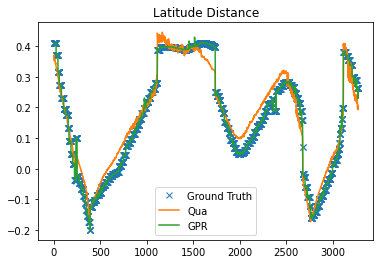

In [28]:
# plotting
plt.plot(ylat_train[mask_train],'x',label='Ground Truth')
plt.plot(delta_lat_quad[mask_train],label='Qua')
plt.plot(lat_gpr_mean,label='GPR')
plt.title('Latitude Distance')
plt.legend()
plt.show()

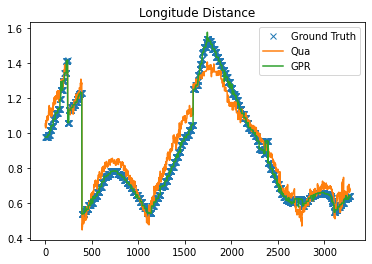

In [29]:
# plotting
plt.plot(ylon_train[mask_train],'x',label='Ground Truth')
plt.plot(delta_lon_quad[mask_train],label='Qua')
plt.plot(long_gpr_mean,label='GPR')
plt.title('Longitude Distance')
plt.legend()
plt.show()

### (4) Neural network
2-layer network is implemented here. 

In [30]:
# neural network
from tensorflow.keras import layers
import tensorflow as tf
from ttictoc import tic,toc
tic()

n_inputs =2


model = tf.keras.Sequential([
layers.Dense(512, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs),
layers.Dense(2, activation='linear')
])
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.fit(X_train.T, y_train)

elapsed = toc()
print('Elapsed time:',elapsed)

188/188 [==============================] - 1s 931us/step - loss: 0.1135 - mae: 0.2356
Elapsed time: 0.8917707999999038


In [31]:
yhat_train = model.predict(X_train[:,mask_train].T)

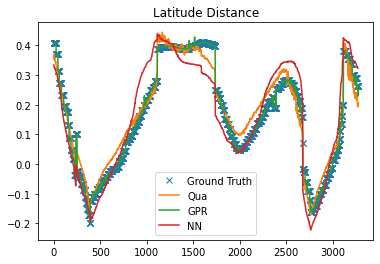

In [32]:
# plotting
plt.plot(ylat_train[mask_train],'x',label='Ground Truth')
plt.plot(delta_lat_quad[mask_train],label='Qua')
plt.plot(lat_gpr_mean,label='GPR')
plt.plot(yhat_train[:,0],label='NN')
plt.title('Latitude Distance')
plt.legend()
plt.show()

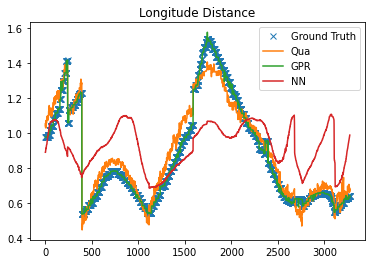

In [33]:
# plotting
plt.plot(ylon_train[mask_train],'x',label='Ground Truth')
plt.plot(delta_lon_quad[mask_train],label='Qua')
plt.plot(long_gpr_mean,label='GPR')
plt.plot(yhat_train[:,1],label='NN')
plt.title('Longitude Distance')
plt.legend()
plt.show()

### (6) Tesing on test dataset

In [63]:
# GPR
lat_gpr_mean_test, lat_gpr_std_test = gpr_lat.predict(X_test[:,mask_test.values].T, return_std=True)
long_gpr_mean_test,long_gpr_std_test= gpr_lon.predict(X_test[:,mask_test.values].T, return_std=True)
# Qua
m_samples = X_test.shape[1]

delta_lat_quad_test = np.zeros((m_samples, 1))
delta_lon_quad_test = np.zeros((m_samples, 1))

a_norm_test = a_norm[6000:]
b_norm_test = b_norm[6000:]

for sample in range(m_samples):
    if mask_test.values[sample]:
        x_sample = np.array([a_norm_test[sample], b_norm_test[sample]])

        delta_lat_quad_test[sample] = quad_fun(x_sample, q_lat)
        delta_lon_quad_test[sample] = quad_fun(x_sample, q_lon)
# NN 
yhat_test = model.predict(X_test[:,mask_test.values].T)

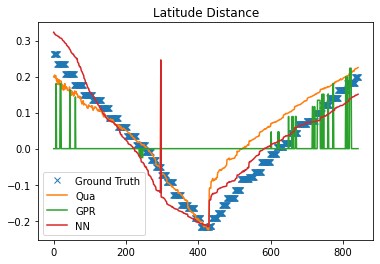

In [65]:
# plot
plt.plot(y_test[mask_test.values,0],'x',label='Ground Truth')
plt.plot(delta_lat_quad_test[mask_test.values],label='Qua')
plt.plot(lat_gpr_mean_test,label='GPR')
plt.plot(yhat_test[:,0],label='NN')
plt.title('Latitude Distance')
plt.legend()
plt.show()

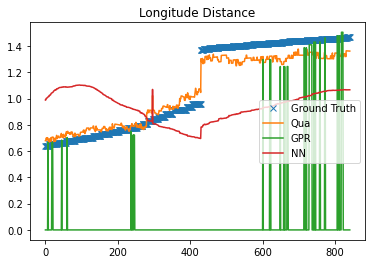

In [66]:
plt.plot(y_test[mask_test.values,1],'x',label='Ground Truth')
plt.plot(delta_lon_quad_test[mask_test.values],label='Qua')
plt.plot(long_gpr_mean_test,label='GPR')
plt.plot(yhat_test[:,1],label='NN')
plt.title('Longitude Distance')
plt.legend()
plt.show()